In [4]:
import numpy as np
import matplotlib.pyplot as plt
T = 5
gamma=0.9
beta=1e-5
n = int(1e5)
# dist = np.random.exponential
rewards_p1 = np.random.exponential(scale=1, size=(n, T))
rewards_p2 = np.random.exponential(scale=1, size=(n, T))
# rewards_p1 = np.random.uniform(low=0, high=40, size=(n, T))
# rewards_p2 = -rewards_p1 #+ np.random.normal(loc=0, scale=1, size=(n,T)) # np.random.uniform(low=0, high=40, size=(n, T)) * rewards_p1
# rewards_p2 = np.random.exponential(scale=10, size=(n, T))
# loc = rewards_p1>25
# rewards_p2 = np.where(rewards_p1>10, rewards_p1, 1)


scores = np.zeros(rewards_p1.shape)

def rloo(rewards):
    scores = np.zeros(rewards_p1.shape)
    rewards[:, -1] = rewards_p1[:, -1]
    for i in range(T-2, -1, -1): scores[:, i] = rewards[:, i] + scores[:, i+1]
    rloo_advs_pi1 = scores - np.sum(scores, axis=0, keepdims=True) / (n-1) + scores / (n-1)
    return rloo_advs_pi1

def get_adv_align_scores(a1, a2, gamma=0.9, beta=1.0):
    discounted_a1 = (gamma*np.ones(shape=(1, T)))**np.arange(0, T, 1)
    discounted_a1 = a1 * discounted_a1
    oppshap_terms = np.zeros(a1.shape)
    tril = np.tril(np.ones((T,T)))
    # print(tril)
    disc_sum_a1 =  discounted_a1 @ tril
    # print(discounted_a1[1, 0:3])
    # print(disc_sum_a1[1, 0:3])
    opponent_shaping_terms = beta * gamma * disc_sum_a1 * a2
    adv_align_terms = a1 + opponent_shaping_terms
    return adv_align_terms, opponent_shaping_terms

Advantage Alignment Scores have the form
\begin{align}
A^*(s_t, a_t, b_t) =
\left(
A^1(s_t, a_t, b_t) + \beta \gamma \cdot 
\left( \sum_{k < t} \gamma^{t-k} A^1(s_k, a_k, b_k) \right) 
A^2(s_t, a_t, b_t)
\right)
\end{align}
with indices starting at $0$.

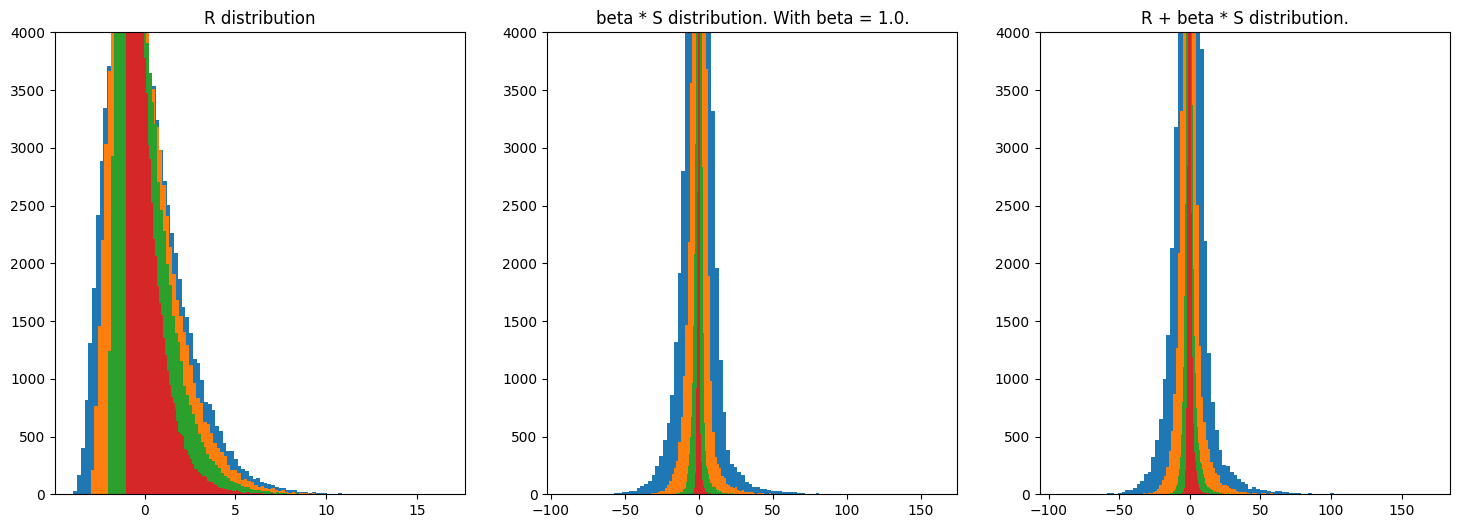

0.2976156616854957


In [5]:
rloo_advs_pi1 = rloo(rewards_p1)
rloo_advs_pi2 = rloo(rewards_p2)
beta = 1.0
adv_align_terms, opponent_shaping_terms = get_adv_align_scores(a1=rloo_advs_pi1, a2=rloo_advs_pi2, gamma=gamma, beta=beta)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(T):
    axs[0].hist(rloo_advs_pi1[:, i], bins=100)
axs[0].set_title("R distribution")
axs[0].set_ylim((0, 4e3))

for i in range(T):
    axs[1].hist(opponent_shaping_terms[:, i], bins=100)
axs[1].set_title(f"beta * S distribution. With beta = {beta}.")
axs[1].set_ylim((0, 4e3))

for i in range(T):
    axs[2].hist(adv_align_terms[:, i], bins=100)
axs[2].set_title("R + beta * S distribution.")
axs[2].set_ylim((0, 4e3))
#axs[2].set_xlim((-1e3, 1e3))

plt.show()
plt.close()

print(np.corrcoef(rloo_advs_pi1.flatten(), adv_align_terms.flatten())[0,1])


We have terms of the form $R + \beta S$, where $R$ is the regular RL score and $\beta S$ is the opponent shaping score. We do not want the $\beta S$ random variables to overshadow the $R$ random variables. We can set $\beta$ to $\frac{\sigma_R}{\sigma_S}$ to even out the variance of the two terms: $\text{var}(\frac{\sigma_R}{\sigma_S}S) = (\frac{\sigma_R}{\sigma_S})^2 \sigma_{S}^2 = \sigma_{R}^2$.

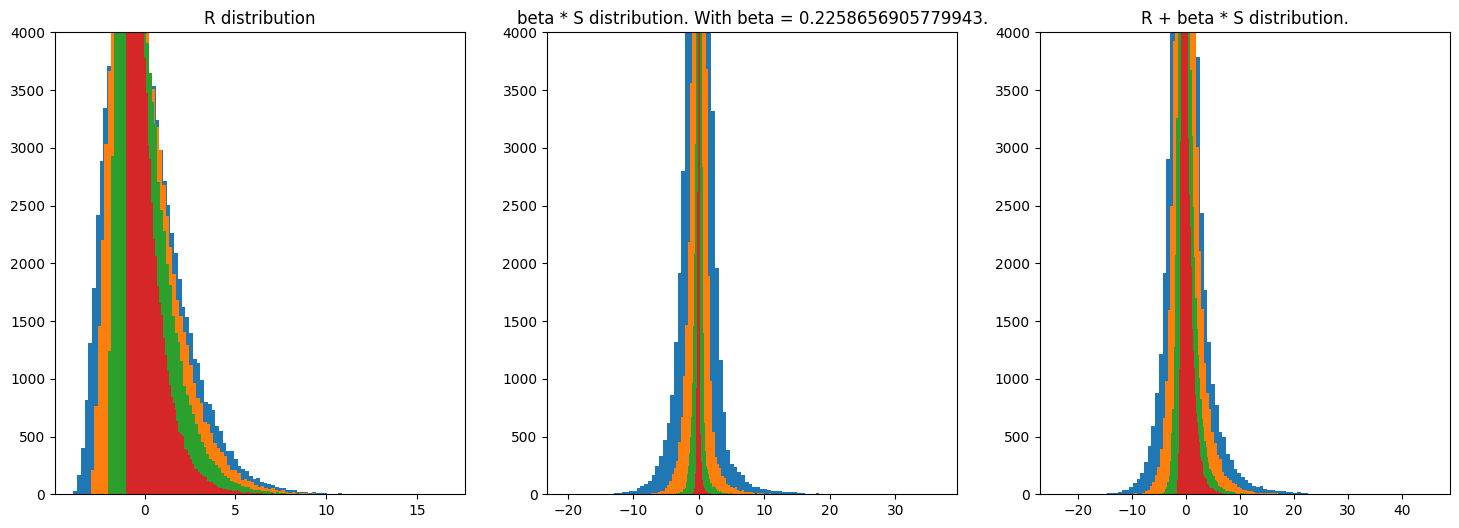

Correlation between R and R+beta*S: 0.805408629947113


In [6]:
beta = np.std(rloo_advs_pi1[:, 0]) / np.std(opponent_shaping_terms[:, 0])

adv_align_terms, opponent_shaping_terms = get_adv_align_scores(a1=rloo_advs_pi1, a2=rloo_advs_pi2, gamma=gamma, beta = beta)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(T):
    axs[0].hist(rloo_advs_pi1[:, i], bins=100)
axs[0].set_title("R distribution")
axs[0].set_ylim((0, 4e3))

for i in range(T):
    axs[1].hist(opponent_shaping_terms[:, i], bins=100)
axs[1].set_title(f"beta * S distribution. With beta = {beta}.")
axs[1].set_ylim((0, 4e3))

for i in range(T):
    axs[2].hist(adv_align_terms[:, i], bins=100)
axs[2].set_title("R + beta * S distribution.")
# axs[2].set_xlim((-200, 200))
axs[2].set_ylim((0, 4e3))

plt.show()
plt.close()
print("Correlation between R and R+beta*S:", np.corrcoef(rloo_advs_pi1.flatten(), adv_align_terms.flatten())[0,1])
# print(np.mean(adv_align_terms[loc]))
# print(np.mean(adv_align_terms[~loc]))